In [23]:
import numpy as np
import numpy.polynomial.polynomial as poly
import math
import pandas as pd
np.set_printoptions(suppress=True)
from keras.models import Sequential
from keras.layers import Dense
import random

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
 

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")


In [24]:
seed = 369

# Polynomial

#### Load data and plot

In [25]:
polynomialdata = pd.read_csv('problem1.csv')

In [26]:
polynomialdata.head()

,X_training,Y_training,X_test,Y_test
0,-2.00,22.067387,2.00,6.024049
1,-1.97,19.944915,2.05,6.885408
2,-1.94,18.062490,2.10,7.578968
3,-1.91,16.384313,2.15,8.439467
4,-1.88,14.567798,2.20,9.554611


In [27]:
len(polynomialdata)

134

In [28]:
polynomialdata['X_test'].isnull().values.any()

True

<AxesSubplot:xlabel='X_training', ylabel='Y_training'>

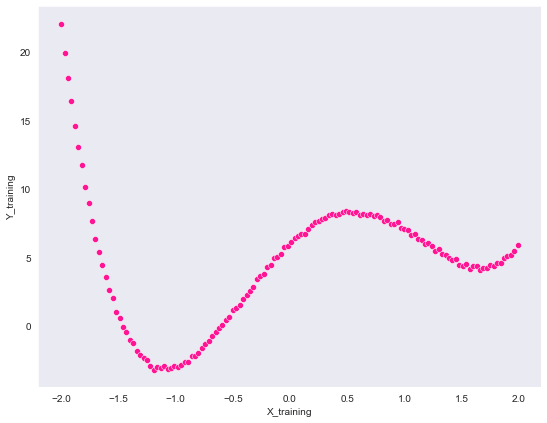

In [29]:
fig, ax = plt.subplots(figsize = (9, 7))
sns.scatterplot(data = polynomialdata, x = 'X_training', y = 'Y_training', color = 'deeppink')

In [30]:
n = len(polynomialdata['X_training'])

In [31]:
degrees = np.arange(2,16)
d = len(degrees)
RSSs = []
AICs = []
for i in range(d):
    coef = poly.polyfit(polynomialdata['X_training'], polynomialdata['Y_training'], degrees[i])
    model = poly.Polynomial(coef)
    RSSs.append(0.5*np.sum((polynomialdata['Y_training'] - model(polynomialdata['X_training']))**2))
    AICs.append(n*math.log10(RSSs[i]/n)+ 2*len(coef)*n/(n-len(coef)-1))
    


In [32]:
names = [str(d) for d in degrees]
comparison = pd.DataFrame({'RSS':RSSs,'AIC':AICs},index = names) 
comparison

,RSS,AIC
2,1350.573365,140.642009
3,412.711631,73.774693
4,0.625376,-301.880366
5,0.625352,-299.689975
6,0.625342,-297.463435
7,0.625144,-295.218711
8,0.621545,-293.255141
9,0.620483,-291.017619
10,0.617910,-288.884124
11,0.612124,-287.017022


In [33]:
grade = np.argmin(AICs)
print("Best AIC grade ocurrs at degree: ", degrees[grade])

Best AIC grade ocurrs at degree:  4


In [34]:
np.argmin(degrees)

0

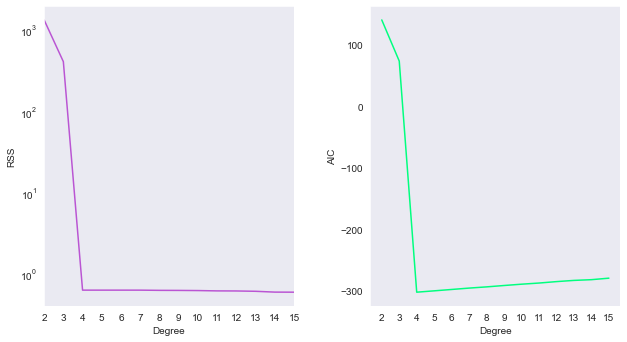

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))

ax1.plot(degrees, RSSs, color = 'mediumorchid')
ax1.set_yscale('log')
ax1.set(xlabel='Degree', ylabel='RSS')
ax1.set(xlim = (np.min(degrees), np.max(degrees)))
ax1.set_xticks(range(np.min(degrees), np.max(degrees)+1))

fig.tight_layout(pad=5.0)
ax2.plot(degrees, AICs, color='springgreen')
ax2.set(xlabel='Degree', ylabel='AIC')
ax1.set(xlim = (np.min(degrees), np.max(degrees)))
ax2.set_xticks(range(np.min(degrees), np.max(degrees)+1))


plt.show()

Fit polynomial on test set and plot, but first remove NANs from dataframe

In [36]:
X_test = polynomialdata[polynomialdata['X_test'].notna()]['X_test']
Y_test = polynomialdata[polynomialdata['Y_test'].notna()]['Y_test']

In [37]:
coef = poly.polyfit(polynomialdata['X_training'], polynomialdata['Y_training'], degrees[grade])
polynomial_model = poly.Polynomial(coef)
polynomial_model

Polynomial([ 6.0000592 ,  8.02956741, -5.99141415, -3.00869471,  1.99588109], domain=[-1,  1], window=[-1,  1])

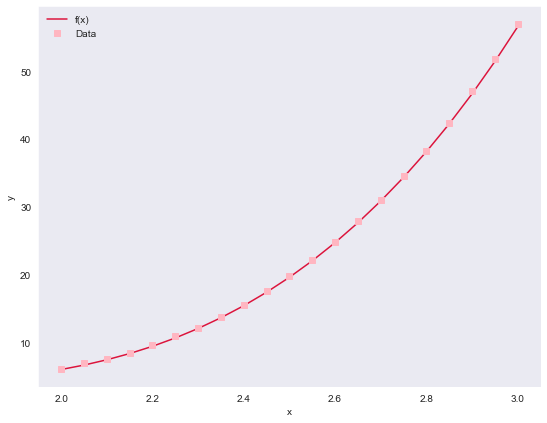

In [38]:
fig, ax = plt.subplots(figsize = (9, 7))
plt.plot(X_test, polynomial_model(X_test), color='crimson', label='f(x)')
plt.plot(X_test, Y_test, 'bs', color='lightpink', label='Data')
plt.legend(loc='best', frameon=False)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# 2. Logic table

Consider the 2-bit binary input ${\bf x} = (x_1, x_2)$ and let the target variable $y$ be $x_1 \$ x_2$ (AND gate) and$x_1 \&x_2$ (NAND gate)

In [39]:
# Truth table (input x) and NAND gate (target)
x_train = np.array([
    [0,0],
    [1,0],
    [0,1],
    [1,1]], dtype = int) # (x1, x2)
y_train_nand = np.array([[1],[1],[1],[0]], dtype = int)
y_train_and = np.array([[0],[0],[0],[1]], dtype = int)

In [40]:
def AND_gate_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim = 2)) 
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile('adam','binary_crossentropy', metrics=['accuracy'])
    return model


In [41]:
def NAND_gate_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim = 2)) # first hidden layer accepts x1, x2 as input
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1,activation='sigmoid')) # output layer
    model.compile('adam','binary_crossentropy', metrics=['accuracy'])
    return model


In [42]:
NANDmodel = NAND_gate_model()
ANDmodel = AND_gate_model()

In [43]:
# Train the models
NANDmodel.fit(x_train, y_train_nand, epochs = 100, verbose=0)

In [44]:
ANDmodel.fit(x_train, y_train_and, epochs = 100, verbose=0)

Now first calculate $A\&B$, which should be equal $(1,1,1,0)$. We can either predict the labels (classes) or the probability, either way it works Ok. 

In [45]:
A = [1.001, 0, 0.001, 1]
B = [0,1,0,1]
x_test_nand = np.dstack((A,B))[0] #np.array([[i, j] for i, j in zip(A,B)])
x_test_nand

array([[1.001, 0.   ],
       [0.   , 1.   ],
       [0.001, 0.   ],
       [1.   , 1.   ]])

In [46]:
D = NANDmodel.predict_classes(x_test_nand) #NANDmodel.predict(x_test_nand)
D

array([[1],
       [1],
       [1],
       [0]])

In [47]:
D = [item for sublist in D for item in sublist]
C = [0,1,1,0]
x_test_and = np.dstack((D,C))[0]
x_test_and

array([[1, 0],
       [1, 1],
       [1, 1],
       [0, 0]])

Now compute $(A\&B)\$C$ should be $=(0,1,1,0)$. Again working 

In [48]:
# Now predict (A&B)$C
final_result = ANDmodel.predict_classes(x_test_and) #Actual classes
final_probs = ANDmodel.predict(x_test_and)# Probabilities

In [49]:
print("Final result: ", final_result)
print("Probs: ", final_probs)

Final result:  [[0]
 [1]
 [1]
 [0]]
Probs:  [[0.03704211]
 [0.9231218 ]
 [0.9231218 ]
 [0.04090002]]


# 3. HIV

In [50]:
hiv = pd.read_csv('problem3.csv')

In [51]:
hiv.head()

,x_age,35,18,22,23,28,38,40,25,35.1,34,25.1,20
0,x_cholesterol,220,240,260,220,180,280,235,200,150,280,275,150
1,x_sugar,80,120,55,75,100,74,175,180,240,130,150,125
2,x_Tcell,550,600,580,575,620,674,275,180,140,80,250,325
3,y,0,0,0,0,0,0,1,1,1,1,1,1


In [52]:
hiv = hiv.transpose() #Transpose
hiv.reset_index(level=0, inplace=True) #Make column index the first row
new_header = hiv.iloc[0] #grab the first row for the header
hiv = hiv[1:] #take the data less the header row
hiv.columns = new_header

In [53]:
hiv.head(12)

,x_age,x_cholesterol,x_sugar,x_Tcell,y
1,35,220,80,550,0
2,18,240,120,600,0
3,22,260,55,580,0
4,23,220,75,575,0
5,28,180,100,620,0
6,38,280,74,674,0
7,40,235,175,275,1
8,25,200,180,180,1
9,35.1,150,240,140,1
10,34,280,130,80,1


In [54]:
len(hiv)

12

In [55]:
y = hiv['y'].to_numpy(dtype = int)

We will first test the age and then Tcell.

In [56]:
model1  = LogisticRegression(C=1.0, solver='lbfgs', multi_class='ovr')
model2 = LogisticRegression(C=1.0, solver='lbfgs', multi_class='ovr')

In [57]:
X_age = hiv['x_age'].to_numpy(dtype = float)
X_age = X_age.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X_age, y, test_size=0.3, random_state=5)


In [58]:
model1.fit(x_train, y_train)
model1.score(x_train, y_train)

0.5

In [59]:
print("Intercept: ", model1.intercept_[0])
print("Coeficient: ", model1.coef_[0][0])

Intercept:  -2.1256635412678975
Coeficient:  0.07596475418262974


In [60]:
X = np.arange(15, 70, 0.1)
X = X.reshape(-1, 1)

Text(0, 0.5, 'Probability of progression')

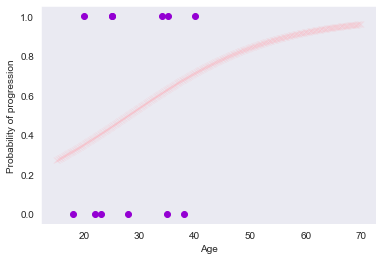

In [64]:
plt.scatter(X_age, y, color = 'darkviolet')
plt.scatter(X, model1.predict_proba(X)[:,1],marker='x',color='lightpink', linewidth = 0.1)
plt.xlabel('Age')
plt.ylabel('Probability of progression')

In [65]:
X_T = hiv['x_Tcell'].to_numpy(dtype = float)
X_T = X_T.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(X_T, y, test_size=0.3, random_state=5)
model2.fit(x_train, y_train)
model2.score(x_train, y_train)

1.0

In [66]:
print("Intercept: ", model2.intercept_[0])
print("Coeficient: ", model2.coef_[0][0])

Intercept:  31.700770791262986
Coeficient:  -0.07262875264742936


Text(0, 0.5, 'Probability of progression')

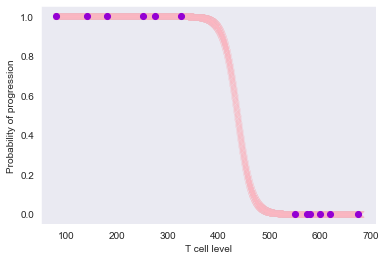

In [67]:
X = np.arange(80, 680, 0.1)
X = X.reshape(-1, 1)
plt.scatter(X, model2.predict_proba(X)[:,1],marker='x',color='lightpink', linewidth = 0.1)
plt.scatter(X_T, y, color = 'darkviolet', linewidth = 1.1)
plt.xlabel('T cell level')
plt.ylabel('Probability of progression')

In [68]:
cm1 = confusion_matrix(y, model1.predict(X_age))
cm2 = confusion_matrix(y, model2.predict(X_T))

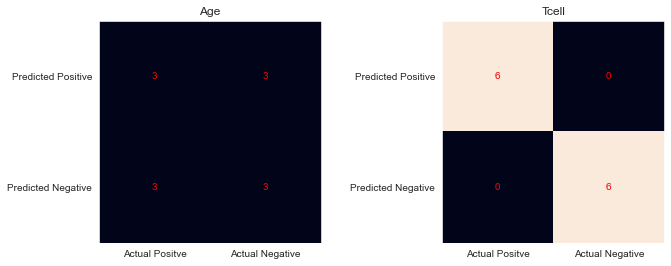

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

ax1.imshow(cm1)
ax1.set_title('Age')
ax1.grid(False)
ax1.yaxis.set(ticks=(0, 1), ticklabels=('Predicted Positive', 'Predicted Negative'))
ax1.xaxis.set(ticks=(0, 1), ticklabels=('Actual Positve', 'Actual Negative'))
ax1.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax1.text(j, i, cm1[i, j], ha='center', va='center', color='red')


fig.tight_layout(pad=10.0)

ax2.imshow(cm2)
ax2.set_title('Tcell')
ax2.grid(False)
ax2.yaxis.set(ticks=(0, 1), ticklabels=('Predicted Positive', 'Predicted Negative'))
ax2.xaxis.set(ticks=(0, 1), ticklabels=('Actual Positve', 'Actual Negative'))
ax2.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax2.text(j, i, cm2[i, j], ha='center', va='center', color='red')
plt.show()



In [70]:
# positive outcome probabilities
lr_probs1 = model1.predict_proba(X_age)[:, 1]
lr_probs2 = model2.predict_proba(X_T)[:, 1]

# Scores
lr_auc1 = roc_auc_score(y, lr_probs1)
lr_auc2 = roc_auc_score(y, lr_probs2)

print('ROC AUC for Age: %.3f' % (lr_auc1))
print('ROC AUC for Tcell: %.3f' % (lr_auc2))

ROC AUC for Age: 0.611
ROC AUC for Tcell: 1.000


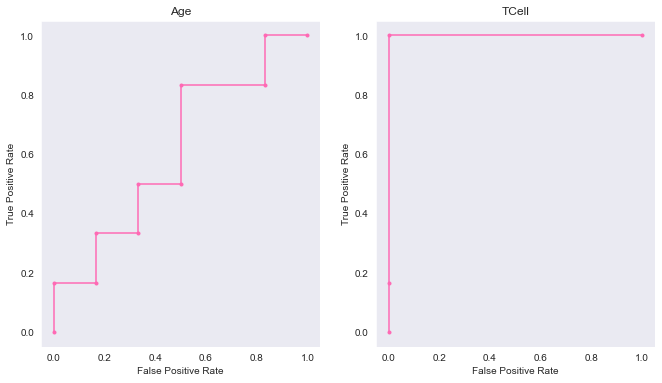

In [71]:
lr_fpr1, lr_tpr1, _ = roc_curve(y, lr_probs1)
lr_fpr2, lr_tpr2, _ = roc_curve(y, lr_probs2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,6))
ax1.plot(lr_fpr1, lr_tpr1, marker='.', color = 'hotpink')
ax1.set(title = 'Age')
ax1.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
ax2.plot(lr_fpr2, lr_tpr2, marker='.', color = 'hotpink')
ax2.set(xlabel = 'False Positive Rate', ylabel = 'True Positive Rate')
ax2.set(title = 'TCell')

plt.show()

# Cone 

In [72]:
def generate_data(T, R):
    X = R * np.cos(T) 
    Y = R * np.sin(T) 
    Z = (np.sqrt(X**2 + Y**2)/(radi/height)) 
    return X, Y, Z

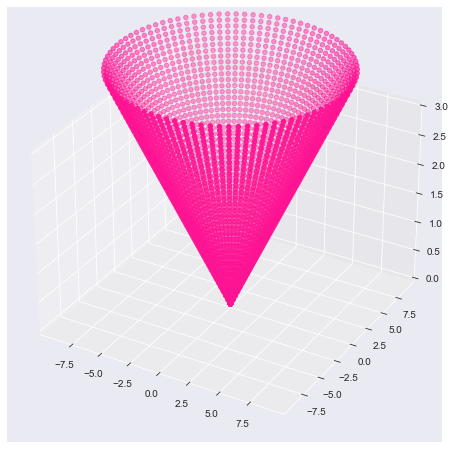

In [73]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')

radi = 9
height = 4
choose = max(radi, height)

theta = np.linspace(0, 2*np.pi, 90)
r = np.linspace(0, choose, 50)
T, R = np.meshgrid(theta, r)

X, Y, Z = generate_data(T, R)
ax.scatter(X, Y, Z, color = 'deeppink')#ax.plot_wireframe(X, Y, Z, color = 'lightpink')
ax.set_zlim(0, 3)

plt.show()

In [74]:
target = Z.reshape(-1,1)
unstacked_x = [item for sublist in X for item in sublist]
unstacked_y = [item for sublist in Y for item in sublist]

In [75]:
inp = np.dstack((unstacked_x, unstacked_y))[0]

In [76]:
def cone_model():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim = 2)) 
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1)) 
    model.compile('adam', loss ='mean_squared_error')
    return model


In [77]:
xy_train, xy_test, z_train, z_test = train_test_split(inp, target, test_size=0.3, random_state=5)

In [78]:
cone = cone_model()
results = cone.fit(xy_train, z_train, validation_split = 0.3, epochs = 100, verbose=1)

Train on 2205 samples, validate on 945 samples
Epoch 1/100
2205/2205 [==============================] - 2s 1ms/step - loss: 0.3481 - val_loss: 0.0016
Epoch 2/100
2205/2205 [==============================] - 0s 105us/step - loss: 7.1458e-04 - val_loss: 1.9913e-04
Epoch 3/100
2205/2205 [==============================] - 0s 104us/step - loss: 8.1264e-05 - val_loss: 5.3450e-05
Epoch 4/100
2205/2205 [==============================] - 0s 104us/step - loss: 3.5626e-05 - val_loss: 2.7191e-05
Epoch 5/100
2205/2205 [==============================] - 0s 98us/step - loss: 2.0748e-05 - val_loss: 1.6968e-05
Epoch 6/100
2205/2205 [==============================] - 0s 106us/step - loss: 1.5039e-05 - val_loss: 1.4216e-05
Epoch 7/100
2205/2205 [==============================] - 0s 102us/step - loss: 1.0165e-05 - val_loss: 8.6564e-06
Epoch 8/100
2205/2205 [==============================] - 0s 102us/step - loss: 8.4926e-06 - val_loss: 7.6539e-06
Epoch 9/100
2205/2205 [==============================] - 0s 

2205/2205 [==============================] - 0s 99us/step - loss: 0.0035 - val_loss: 3.7526e-04
Epoch 74/100
2205/2205 [==============================] - 0s 105us/step - loss: 9.8962e-05 - val_loss: 1.8059e-05
Epoch 75/100
2205/2205 [==============================] - 0s 100us/step - loss: 9.9771e-06 - val_loss: 7.9475e-06
Epoch 76/100
2205/2205 [==============================] - 0s 112us/step - loss: 6.3293e-06 - val_loss: 4.0031e-06
Epoch 77/100
2205/2205 [==============================] - 0s 102us/step - loss: 3.7096e-06 - val_loss: 6.1899e-06
Epoch 78/100
2205/2205 [==============================] - 0s 101us/step - loss: 3.6451e-06 - val_loss: 3.1767e-06
Epoch 79/100
2205/2205 [==============================] - 0s 98us/step - loss: 2.6731e-06 - val_loss: 3.1861e-06
Epoch 80/100
2205/2205 [==============================] - 0s 96us/step - loss: 3.5409e-06 - val_loss: 2.2789e-06
Epoch 81/100
2205/2205 [==============================] - 0s 99us/step - loss: 2.6568e-06 - val_loss: 1.1694

In [79]:
predictions = cone.predict(xy_test)

In [80]:
preds = [item for sublist in predictions for item in sublist]
x_test = [item for sublist in xy_test for item in sublist[::2]]
y_test  =  [item for sublist in xy_test for item in sublist[1::2]]

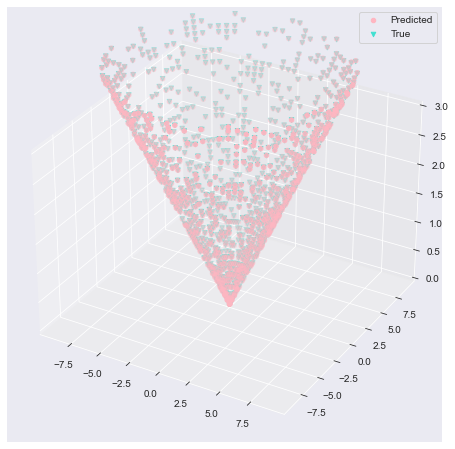

In [81]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(x_test, y_test, preds, color = 'lightpink', marker='o', label = 'Predicted')
ax.scatter(x_test, y_test, z_test, color = 'turquoise', marker='v', label = 'True')
ax.set_zlim(0, 3)
plt.legend()
plt.show()